In [21]:
import numpy as np
from scipy import special
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

In [22]:
ME=9.10938356E-31                       # electron mass, in kilogram
MI=1.6726219E-27                 # ion mass, in kilogram
QE=1.60217662E-19                # elementary charge, in coulomb
EPSILON0=8.8541878128E-12

In [23]:
def erf(x): return special.erf(x)

In [24]:
erf(1)

0.8427007929497148

In [25]:
def nu_ab(n, qa, qb, log, ma):
    return n * (qa**2) * (qb**2) * log / (4*np.pi * (EPSILON0**2) * (ma**2))

In [26]:
nu_ab(1E19, QE, -1*QE, 20, MI)

4.781549697703446e+19

In [27]:
def x(v, temp, mb):
    vt = np.sqrt(2*temp/mb);
    return v/vt

In [28]:
def G(x):
    gauss = ((2 * x) / np.sqrt(np.pi)) * np.exp(-1 * x**2);
    return (erf(x) - gauss)/(2 * x**2)

In [29]:
test = np.linspace(0.001, 5, 100)

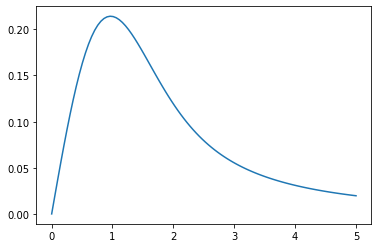

In [30]:
plt.plot(test, G(test))

In [31]:
def nu_s(v, ma, mb, qa, qb, temp, n):
    speed = np.linalg.norm(v, axis = -1)
    xb = x(speed, temp, mb);
    return (1/(speed*temp))*G(xb)* (ma+mb) * nu_ab(n, qa, qb, 19, ma)

In [32]:
nu_perp([1E6,0, 0], MI, MI, QE, QE, 200*QE, 1E19)

44.55449045462042

In [33]:
def nu_par(v, ma, mb, qa, qb, temp, n):
    speed = np.linalg.norm(v, axis = -1)
    xb = x(speed, temp, mb)
    return 2 * nu_ab(n, qa, qb, 19, ma) * G(xb) / (speed ** 3)

def nu_perp(v, ma, mb, qa, qb, temp, n):
    speed = np.linalg.norm(v, axis = -1)
    xb = x(speed, temp, mb)
    return nu_ab(n, qa, qb, 19, ma) * (erf(xb) - G(xb))/ (speed ** 3)

def diffusion(dt, v, ma, mb, qa, qb, temp, n):
    '''returns the diffusion dv vector'''
    bs = v.shape[0] #batch size of velocities
    
    nupara = nu_par(v, ma, mb, qa, qb, temp, n)
    nuperp = nu_perp(v, ma, mb, qa, qb, temp, n)
    
    speed = np.linalg.norm(v, axis = -1)
    Dperp_sqrt = speed * np.sqrt(0.5 * nuperp)
#     Dperp_sqrt = Dperp_sqrt / Dperp_sqrt # setting diffusion coef to 1
    Dpara_sqrt  = speed * np.sqrt(0.5 * nupara)*0
    #print(Dpara_sqrt.shape)

    diag = np.identity(3)
    
    identities = np.tile(diag, (bs, 1)).reshape(bs, 3, 3)
    
    vvs = v[:, :, None] * v[:, None, :] / (speed**2)[:, None, None]
    #print(np.linalg.norm((identities - vvs), ord = 2, axis = (1, 2)))
    
    D_mat = vvs * Dpara_sqrt[:, None, None] + (identities - vvs) * Dperp_sqrt[:, None, None]
    #D_mat = vvs * Dperp_sqrt[:, None, None] + (identities - vvs) * Dperp_sqrt[:, None, None]
    
    mean = [0, 0, 0]
    var = [[dt, 0, 0], [0, dt, 0], [0, 0, dt]]
    wiener = np.random.multivariate_normal(mean, var, bs)
    wiener = np.expand_dims(wiener, axis = -1)
    #print(wiener.T)
#     v = np.expand_dims(v, axis = -1)
    return np.squeeze(np.matmul(D_mat, wiener), -1)
    #return np.squeeze(np.matmul(identities, wiener), -1)

In [34]:
v0 = np.array([[1, 0, 0], [1, 1, 0], [3, 44, 5]])
print(v0)
vs = v0[:, :, None] * v0[:, None, :]
speed = np.linalg.norm(v0, axis = -1)
print(speed)
identities = np.tile(np.identity(3), (3, 1)).reshape(3, 3, 3)
print(identities)
print(identities - vs)
print('..>.<..')

print(speed)
print((identities-vs) * speed[:, None,None])

[[ 1  0  0]
 [ 1  1  0]
 [ 3 44  5]]
[ 1.          1.41421356 44.38468204]
[[[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]

 [[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]

 [[1. 0. 0.]
  [0. 1. 0.]
  [0. 0. 1.]]]
[[[ 0.000e+00  0.000e+00  0.000e+00]
  [ 0.000e+00  1.000e+00  0.000e+00]
  [ 0.000e+00  0.000e+00  1.000e+00]]

 [[ 0.000e+00 -1.000e+00  0.000e+00]
  [-1.000e+00  0.000e+00  0.000e+00]
  [ 0.000e+00  0.000e+00  1.000e+00]]

 [[-8.000e+00 -1.320e+02 -1.500e+01]
  [-1.320e+02 -1.935e+03 -2.200e+02]
  [-1.500e+01 -2.200e+02 -2.400e+01]]]
..>.<..
[ 1.          1.41421356 44.38468204]
[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 0.00000000e+00 -1.41421356e+00  0.00000000e+00]
  [-1.41421356e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.41421356e+00]]

 [[-3.55077456e+02 -5.85877803e+03 -6.65770231e+02]
  [-5.85877803e+03 -8.58843598e+04 -9.76463005e+0

[[ 0.15625125 -1.27859065  0.72043191]
 [-1.41012456  0.5328937  -0.54271324]
 [-0.64359244 -0.36955408  0.68540748]
 ...
 [ 1.6298458   2.58698089 -0.19409313]
 [-1.08437589 -0.22345981 -0.51586598]
 [ 0.05701932 -1.321899    0.79934001]]


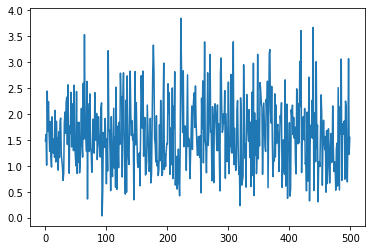

In [179]:
mean = [0, 0, 0]
var = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
wiener = np.random.multivariate_normal(mean, var, 500)
norm = np.linalg.norm(wiener, axis = -1)
print(wiener)
plt.plot(norm)

In [104]:
np.linalg.norm([[1, 0, 0], [0, 1, 0], [0, 0, 0]], ord = 2)

1.0

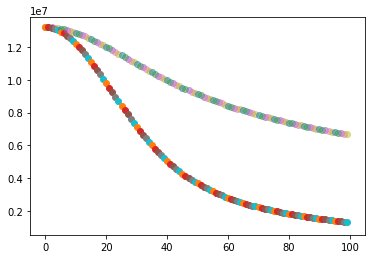

In [184]:
%matplotlib inline
vtest = np.linspace(0.1, 1E6, 100)
for i in range(len(vtest)):
    plt.scatter(i, vtest[i] * np.sqrt(nu_perp([vtest[i]], MI, MI, QE, QE, 200*QE, 1E19)), alpha = 0.5)
    plt.scatter(i, vtest[i] * np.sqrt(nu_par([vtest[i]], MI, MI, QE, QE, 200*QE, 1E19)))

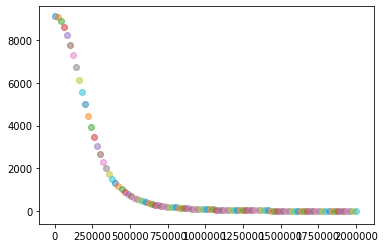

In [244]:
%matplotlib inline
vtest = np.linspace(0.1, 2E6, 100)
for i in range(len(vtest)):
    plt.scatter(vtest[i], nu_s([vtest[i]], MI, MI, QE, QE, 200*QE, 1E19), alpha = 0.5)

In [ ]:
vtest = np.linspace(0.1, 1E5, 100)

nupara = nu_par([vtest[i]], MI, MI, QE, QE, 200*QE, 1E19)
nuperp = nu_perp([vtest[i]], MI, MI, QE, QE, 200*QE, 1E19)
    

speed = np.linalg.norm([vtest], axis = -1)
Dperp_sqrt = speed * np.sqrt(0.5 * nuperp)
Dpara_sqrt  = speed * np.sqrt(0.5 * nupara)

In [35]:
def randomStart(E, Tb, nb, nparts, dt, tTot):
    '''Start nparts number of particles at random velocities according to Gaussian, with thermal energy E
    E[eV]:     Energy of fast particles (thermal)
    Tb[eV]:    Temperature of background ions
    nb[m^-3]:  Density of background ions
    nparts[#]: Number of particles
    dt[s]:     Time step
    tTot[s]:   Total simulation time
    return[np.array]: history of velocities (timesteps x nparts x 3)
    '''
    v_mean = np.sqrt(2*E*QE/MI)
    mean = [0, 0, 0]
    var = [[v_mean**2, 0, 0], [0, v_mean**2, 0], [0, 0, v_mean**2]]
    v_init = np.random.multivariate_normal(mean, var, nparts)
    
    v = v_init
    tb = Tb * QE
    tnow = 0
    bs = v.shape[0]
    vHist = np.array([v_init])
    while tnow < tTot:
        nus = nu_s(v, MI, MI, QE, QE, tb, nb).reshape(bs, 1)
        dv_s = -1 * dt* nus * v
        dv_diff = diffusion(dt, v, MI, MI, QE, QE, tb, nb)
        v = v + dv_s + dv_diff
        vHist = np.append(vHist,np.array([v]), axis = 0)
        tnow += dt
    return vHist

In [36]:
def beamStart(E, Tb, nb, nparts, dt, tTot, damp, diffuse):
    '''Start nparts number of particles at uniform beam velocity, with directed energy E
    E[eV]:     Energy of beam fast particles (1D directed)
    Tb[eV]:    Temperature of background ions
    nb[m^-3]:  Density of background ions
    nparts[#]: Number of particles
    dt[s]:     Time step
    tTot[s]:   Total simulation time
    damp[1/0]:      On/off switch for friction slowing down
    diffuse[1/0]:   On/off switch for diffusion
    return[np.array]: history of velocities (timesteps x nparts x 3)
    '''
    v_beam = np.sqrt(2*E*QE/MI)
    v_init = np.tile(np.array([v_beam, 0, 0]), (nparts, 1)) # initialize nparts particles with same velocity
    
    v = v_init
    tb = Tb * QE
    tnow = 0
    bs = v.shape[0]
    vHist = np.array([v_init])
    while tnow < tTot:
        nus = nu_s(v, MI, MI, QE, QE, tb, nb).reshape(bs, 1)
        dv_s = -1 * dt* nus * v * damp
        dv_diff = diffusion(dt, v, MI, MI, QE, QE, tb, nb) * diffuse
        v = v + dv_s + dv_diff
        vHist = np.append(vHist,np.array([v]), axis = 0)
        tnow += dt
    return vHist

(1001, 30, 3)
(1001, 30)


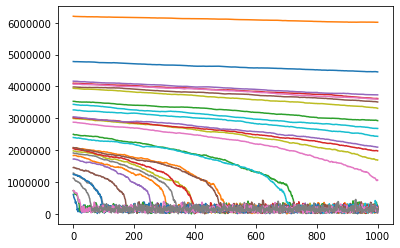

In [225]:
vHist = randomStart(17000, 200, 1E19, 30, 1E-4, 0.1)
print(vHist.shape)
speed = np.linalg.norm(vHist, axis = -1)
print(speed.shape)
figure = plt.plot(speed)

(501, 100, 3)
(501, 100)


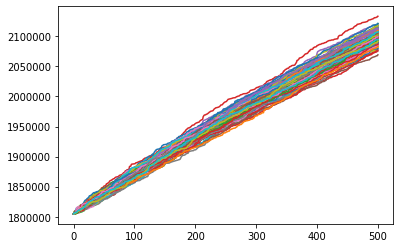

In [37]:
vHistBeam4 = beamStart(17000, 200, 1E19, 100, 1E-4, 0.05, 0, 1)
print(vHistBeam4.shape)
speedBeam4 = np.linalg.norm(vHistBeam4, axis = -1)
print(speedBeam4.shape)
figure = plt.plot(speedBeam4)

In [485]:
def convergenceTest(nparts, start, end, numTrials):
    order = start
    dtList = np.array([])
    meanList = np.array([])
    varList = np.array([])
    while order <= end:
        dt = 10**order
        print(dt)
        i = 0
        while i < numTrials:
            vHist = beamStart(17000, 200, 1E19, nparts, dt, 0.1, 0, 1)
            print('done tracing')
            speedHist = np.linalg.norm(vHist, axis = -1)**2
            dtList = np.append(dtList, dt)
            final = speedHist[len(speedHist)-1,:]
            meanList = np.append(meanList, np.mean(final))
            varList = np.append(varList, np.var(final))
            i+=1
        order+=0.2
    return dtList, meanList, varList, speedHist[0, 0]

In [486]:
a, b, c, init = convergenceTest(100, -5, -2, 5)

1e-05
done tracing
done tracing
done tracing
done tracing
done tracing
1.584893192461114e-05
done tracing
done tracing
done tracing
done tracing
done tracing
2.5118864315095822e-05
done tracing
done tracing
done tracing
done tracing
done tracing
3.9810717055349776e-05
done tracing
done tracing
done tracing
done tracing
done tracing
6.309573444801943e-05
done tracing
done tracing
done tracing
done tracing
done tracing
0.00010000000000000021
done tracing
done tracing
done tracing
done tracing
done tracing
0.00015848931924611174
done tracing
done tracing
done tracing
done tracing
done tracing
0.0002511886431509587
done tracing
done tracing
done tracing
done tracing
done tracing
0.00039810717055349854
done tracing
done tracing
done tracing
done tracing
done tracing
0.0006309573444801956
done tracing
done tracing
done tracing
done tracing
done tracing
0.0010000000000000041
done tracing
done tracing
done tracing
done tracing
done tracing
0.0015848931924611206
done tracing
done tracing
done t

Text(0.5, 1.0, 'Error in Speed')

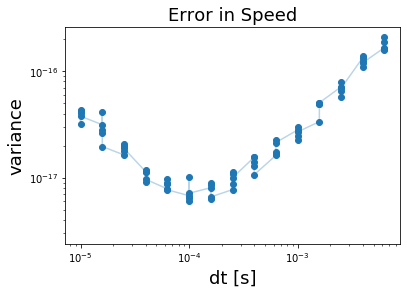

In [483]:
plt.plot(a, c, alpha = 0.3)
plt.scatter(a, c)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('variance', fontsize = 18)
plt.xlabel('dt [s]', fontsize = 18)
plt.title('Error in Speed', fontsize = 18)

Text(0.5, 1.0, 'Error in Speed')

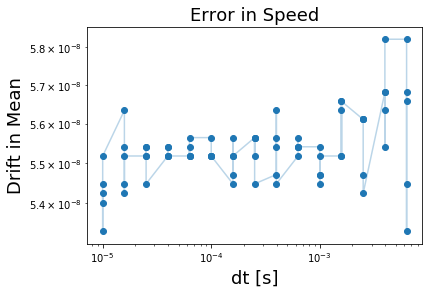

In [484]:
plt.plot(a, (b-init), alpha = 0.3)
plt.scatter(a, (b-init))
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Drift in Mean', fontsize = 18)
plt.xlabel('dt [s]', fontsize = 18)
plt.title('Error in Speed', fontsize = 18)

Text(0.5, 1.0, 'Error in Energy')

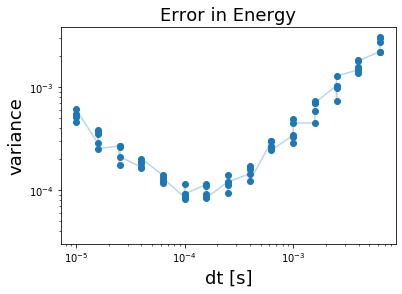

In [487]:
plt.plot(a, c, alpha = 0.3)
plt.scatter(a, c)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('variance', fontsize = 18)
plt.xlabel('dt [s]', fontsize = 18)
plt.title('Error in Energy', fontsize = 18)

Text(0.5, 1.0, 'Error in Energy')

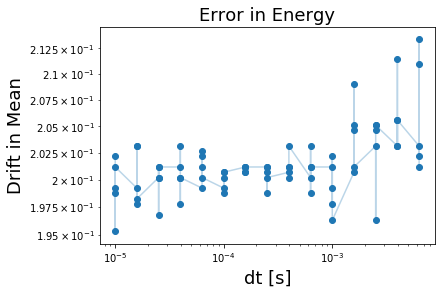

In [488]:
plt.plot(a, (b-init), alpha = 0.3)
plt.scatter(a, (b-init))
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Drift in Mean', fontsize = 18)
plt.xlabel('dt [s]', fontsize = 18)
plt.title('Error in Energy', fontsize = 18)

(6, 100, 3)
(6, 100)


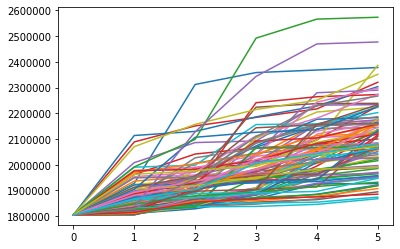

In [38]:
vHistBeam2 = beamStart(17000, 200, 1E19, 100, 1E-2, 0.05, 0, 1)
print(vHistBeam2.shape)
speedBeam2 = np.linalg.norm(vHistBeam2, axis = -1)
print(speedBeam2.shape)
figure = plt.plot(speedBeam2)

Text(0.5, 0, 'Time [s]')

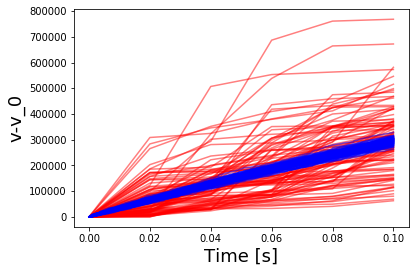

In [39]:
%matplotlib inline
time2 = np.linspace(0, 0.1, 6)
time4 = np.linspace(0, 0.1, 501)
figure = plt.plot(time2, speedBeam2-speedBeam2[0, :], 'r', alpha = 0.5)
figure = plt.plot(time4, speedBeam4-speedBeam4[0, :], 'b', alpha = 0.5)

# plt.yscale('log')
plt.ylabel('v-v_0', fontsize = 18)
plt.xlabel('Time [s]', fontsize = 18)


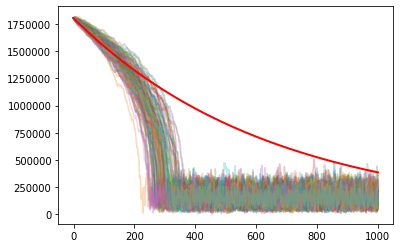

In [259]:
v_beam = np.sqrt(2*17000*QE/MI)
nus = nu_s([v_beam], MI, MI, QE, QE, 200*QE, 1E19)
t = np.linspace(0, 0.1, 1000)
plt.plot(speedBeam, alpha = 0.3)
plt.plot(t*10000, v_beam * np.exp(-1 * nus*t),'r', linewidth=2)


(1001, 100, 3)
(1001, 100)


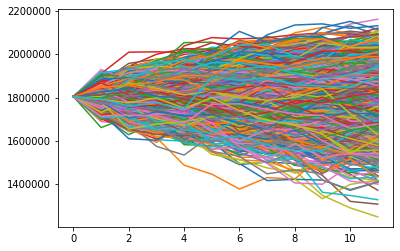

In [354]:
vHistBeam2 = beamStart(17000, 200, 1E19, 2000, 1E-2, 0.1, 0, 1)
print(vHistBeam.shape)
speedBeam2 = np.linalg.norm(vHistBeam2, axis = -1)
print(speedBeam.shape)
figure = plt.plot(speedBeam2)

(1001, 100, 3)
(1001, 100)


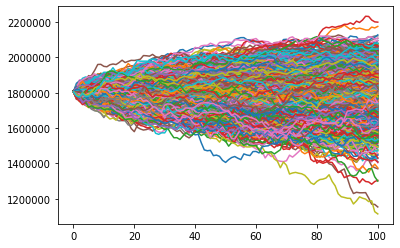

In [355]:
vHistBeam3 = beamStart(17000, 200, 1E19, 2000, 1E-3, 0.1, 0, 1)
print(vHistBeam.shape)
speedBeam3 = np.linalg.norm(vHistBeam3, axis = -1)
print(speedBeam.shape)
figure = plt.plot(speedBeam3)

(1001, 100, 3)
(1001, 100)


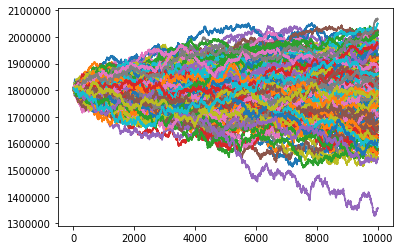

In [330]:
vHistBeam5 = beamStart(17000, 200, 1E19, 200, 1E-5, 0.1, 0, 1)
print(vHistBeam.shape)
speedBeam5 = np.linalg.norm(vHistBeam5, axis = -1)
print(speedBeam.shape)
figure = plt.plot(speedBeam5)

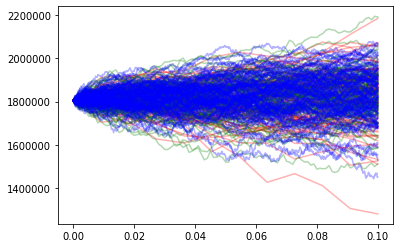

In [304]:
time2 = np.linspace(0, 0.1, 12)
time3 = np.linspace(0, 0.1, 101)
time4 = np.linspace(0, 0.1, 1001)
plt.plot(time2, speedBeam2, 'r', alpha = 0.3)
plt.plot(time3, speedBeam3, 'g', alpha = 0.3)
plt.plot(time4, speedBeam4, 'b', alpha = 0.3)

/Users/xinzhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys


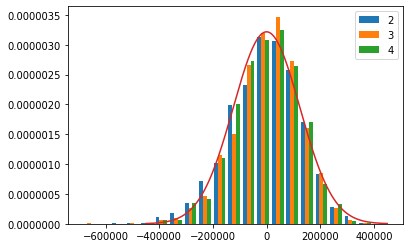

In [361]:
data = [speedBeam2[len(speedBeam2)-1,:] - speedBeam2[0, :], speedBeam3[len(speedBeam3)-1,:] - speedBeam3[0, :],speedBeam4[len(speedBeam4)-1,:] - speedBeam4[0, :], speedBeam5[len(speedBeam5)-1,:] - speedBeam5[0, :]]
mu = np.mean(np.mean(data[:-1], axis = -1)) # average mean
var = np.mean(np.var(data[:-1], axis = -1)) # average variance
x = np.linspace(-450000, 450000, 2000)
y = 1.0/np.sqrt(2*np.pi*var)*np.exp(-0.5*(x)**2/var) #A gaussian with 0 mean and the average variance

plt.hist(data[:-1], bins = 20, label = [2, 3, 4], normed = True)
plt.plot(x, y)
plt.legend()

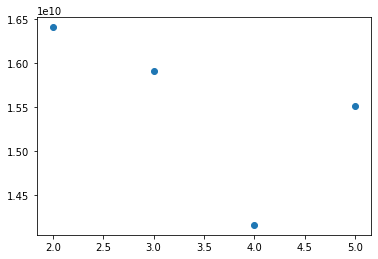

In [332]:
plt.scatter([2, 3, 4, 5], [np.var(speedBeam2[len(speedBeam2)-1,:]), np.var(speedBeam3[len(speedBeam3)-1,:]), np.var(speedBeam4[len(speedBeam4)-1,:]), np.var(speedBeam5[len(speedBeam5)-1,:])])

<IPython.core.display.Javascript object>


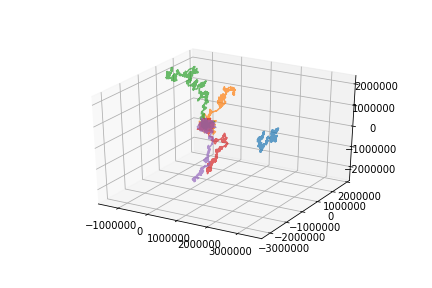

In [81]:
%matplotlib inline
fig = plt.figure(0)
ax = fig.add_subplot(111, projection='3d')

traces = np.transpose(vHist, (2, 1, 0))
for i in np.arange(5):
    ax.plot(traces[0][i], traces[1][i], traces[2][i], alpha = 0.7)
plt.show()
#timeslice = transposed[500]
#ax.scatter(timeslice[0], timeslice[1], timeslice[2])

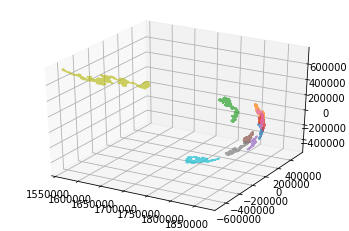

In [216]:
%matplotlib inline
fig = plt.figure(1)
ax = fig.add_subplot(111, projection='3d')

traces = np.transpose(vHistBeam, (2, 1, 0))
for i in np.arange(10):
    ax.plot(traces[0][i][9000:10002], traces[1][i][9000:10002], traces[2][i][9000:10002], alpha = 0.7)


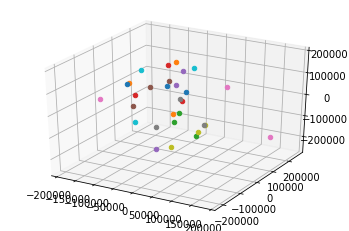

In [195]:
%matplotlib inline
fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111, projection='3d')
timeslice = vHistBeam[3000]
for item in timeslice:
    ax2.scatter(item[0], item[1], item[2])

In [42]:
v1 = [1, 2, 3]
v2 = [2, 3, 4]
outerproduct = np.outer(v1, v2)
print(outerproduct)

[[ 2  3  4]
 [ 4  6  8]
 [ 6  9 12]]


In [46]:
vv1 = np.array([v1, v1])
vv2 = np.array([v2, v2])
print(vv1)
print(vv2)
print(vv1[:, :, None] * vv2[:, None, :])

[[1 2 3]
 [1 2 3]]
[[2 3 4]
 [2 3 4]]
[[[ 2  3  4]
  [ 4  6  8]
  [ 6  9 12]]

 [[ 2  3  4]
  [ 4  6  8]
  [ 6  9 12]]]
